In [1]:
import torch
import torch.nn as nn
import os
import cv2
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
from torchvision import models
from torchvision import transforms
import os

In [3]:
if(os.path.split(os.getcwd())[1] == "Transfer_Learning" or os.path.split(os.getcwd())[1] == "semi-supervised" or os.path.split(os.getcwd())[1] == "self-supervised"):
    os.chdir("..")
print("Current Working Directory: {}".format(os.path.split(os.getcwd())[1]))

Current Working Directory: progettoVIPM


In [4]:
cuda=True

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
from utils.loadersAndEnums import datasets, ImageDataset
from torch.utils.data import DataLoader, ConcatDataset, random_split

trainL = ImageDataset(dataset=datasets.TRAINING_LABELED_80,network_input_size=256, cuda=cuda, normalize=True)
trainU = ImageDataset(dataset=datasets.ASSIGNED_LABELS_20,network_input_size=256, cuda=cuda, normalize=True)
trainC = ConcatDataset([trainL,trainU])

In [19]:

test = ImageDataset(dataset=datasets.TEST,network_input_size=256,cuda=cuda, normalize=True)
valL = ImageDataset(dataset=datasets.VALIDATION_LABELED_20,network_input_size=256,cuda=cuda, normalize=True)

trainL = DataLoader(trainL,64,True)
trainC = DataLoader(trainC,64,True)
test = DataLoader(test,64,True)
valL = DataLoader(valL,64,True)

In [8]:
class ColorizationModel(nn.Module):
    def __init__(self):
        super(ColorizationModel, self).__init__()
        # Encoder: Convolutional layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output size: 64 x 128 x 128

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output size: 128 x 64 x 64

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # Output size: 256 x 32 x 32
        )
        # Decoder: Deconvolutional layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 2, kernel_size=4, stride=2, padding=1),  # Output 2 channels (a, b)
            nn.Tanh()  # Normalize output to range [-1, 1]
        )

    def forward(self, x):
        features = self.encoder(x)
        output = self.decoder(features)
        return output

In [9]:
best_model_path = 'self-supervised/models/best_Colorizer.pth'
colorizer = ColorizationModel()
colorizer.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [10]:
class ExtendedColorizer(nn.Module):
    def __init__(self, colorizer):
        super(ExtendedColorizer, self).__init__()
        self.encoder = colorizer.encoder
        self.ff1 = nn.Linear(256*32*32, 1024)
        self.relu = nn.ReLU()
        self.ff2 = nn.Linear(1024, 251)
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(p=0.5)
        for param in self.encoder.parameters():
            param.requires_grad = False
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(-1, 256*32*32)
        x = self.ff1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.ff2(x)
        x = self.dropout(x)
        x = self.softmax(x)
        return x

In [11]:
def show_image(image):
    """
    Function to display an image using matplotlib.pyplot
    :param image: Input image (numpy array or torch tensor)
    """
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.axis('off')
    plt.show()
def renormalize(tensor):
    minFrom = tensor.min()
    maxFrom = tensor.max()
    minTo = 0
    maxTo = 1
    return minTo + (maxTo - minTo) * ((tensor - minFrom) / (maxFrom - minFrom))

In [12]:
def process_batch(batch):
    batch = batch.cpu().numpy()
    batch = np.moveaxis(batch, 1, -1)  # Move channel axis to the end
    lab_batch = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2LAB) for img in batch])
    
    L_batch = lab_batch[:,:,:,0] / 255.0
    ab_batch = lab_batch[:,:,:,1:] / 128.0
    
    L_batch = torch.tensor(L_batch, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
    ab_batch = torch.tensor(ab_batch, dtype=torch.float32).permute(0, 3, 1, 2)  # Move channel axis to the second position
    
    return L_batch, ab_batch

In [20]:
exColorizer = ExtendedColorizer(colorizer)
exColorizer.to(device)
exColorizer.to(device)
train_loss = []
val_loss = []
train_acc = []
val_acc = []
num_epochs = 100
best_val_loss = float('inf')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(exColorizer.parameters(), lr = 1e-6)
best_model_path = 'self-supervised/models/best_Label_Extended_Colorizer_classifier.pth'
for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1}')
    exColorizer.train()
    running_loss = 0.0
    correct = 0
    total = 0
    i = 0
    print("Training:")
    for inputs, labels in trainC:
        i=i+1
        if i%10 == 0:
            print(f'Batch {i} di {len(trainC)}')
        labels = [int(label) for label in labels]
        inputs,_ = process_batch(inputs)
        
        inputs = inputs.to(device) 
        labels = torch.tensor(labels, dtype=torch.long).to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = exColorizer(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Training Loss: {running_loss/len(trainC)}, Accuracy: {100*correct/total}%')
    train_acc.append(100*correct/total)
    train_loss.append(running_loss/len(trainC))
    print('Validation:')
    exColorizer.eval()
    running_loss = 0.0
    i = 0
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs,labels in valL:
            i+=1
            if i%10 == 0:
                print(f'Batch {i} di {len(valL)}')            
            labels=[int(lable) for lable in labels]
            inputs,_ = process_batch(inputs)
            inputs,labels = inputs.to(device), torch.tensor(labels,dtype=torch.long).to(device)
            outputs = exColorizer(inputs)
            _,predicted = torch.max(outputs,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs,labels)
            running_loss += loss.item()
    val_loss_epoch = running_loss / len(valL)
    print(f'Validation Loss: {val_loss_epoch}, Accuracy: {100*correct/total}%')
    val_loss.append(running_loss/len(valL))
    val_acc.append(100*correct/total)
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        torch.save(exColorizer.state_dict(), best_model_path)
        print(f'Best model saved with validation loss: {best_val_loss}')

Epoch: 1
Training:
Batch 10 di 133
Batch 20 di 133
Batch 30 di 133
Batch 40 di 133
Batch 50 di 133
Batch 60 di 133
Batch 70 di 133
Batch 80 di 133
Batch 90 di 133
Batch 100 di 133
Batch 110 di 133
Batch 120 di 133
Batch 130 di 133
Training Loss: 5.52461618409121, Accuracy: 0.8036875073868337%
Validation:
Batch 10 di 16
Validation Loss: 5.525525510311127, Accuracy: 0.398406374501992%
Best model saved with validation loss: 5.525525510311127
Epoch: 2
Training:
Batch 10 di 133
Batch 20 di 133
Batch 30 di 133
Batch 40 di 133
Batch 50 di 133
Batch 60 di 133
Batch 70 di 133
Batch 80 di 133
Batch 90 di 133
Batch 100 di 133
Batch 110 di 133
Batch 120 di 133
Batch 130 di 133
Training Loss: 5.518041635814466, Accuracy: 1.4182720718591184%
Validation:
Batch 10 di 16
Validation Loss: 5.525624752044678, Accuracy: 0.398406374501992%
Epoch: 3
Training:
Batch 10 di 133
Batch 20 di 133
Batch 30 di 133
Batch 40 di 133
Batch 50 di 133
Batch 60 di 133
Batch 70 di 133
Batch 80 di 133
Batch 90 di 133
Batch 1

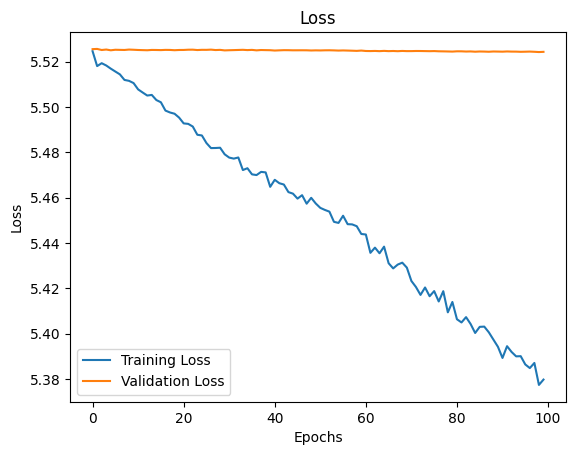

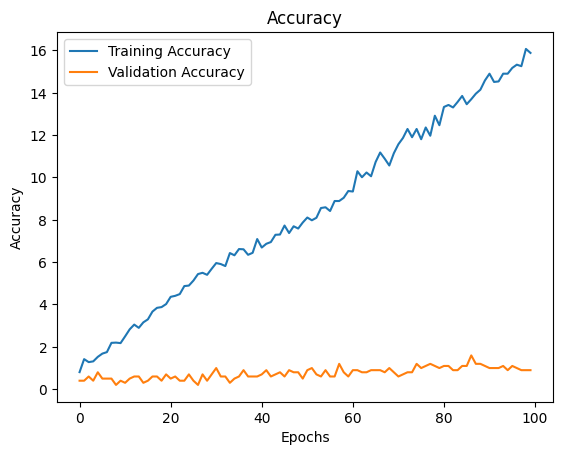

In [21]:
def plot_loss(train_loss,val_loss):
    fig, ax = plt.subplots()


    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Loss')
    ax.plot(train_loss, label='Training Loss')
    ax.plot(val_loss, label='Validation Loss')
    ax.legend()

    plt.show()
    
def plot_accuracy(train_acc,val_acc):
    fig, ax = plt.subplots()


    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy')
    ax.plot(train_acc, label='Training Accuracy')
    ax.plot(val_acc, label='Validation Accuracy')
    ax.legend()

    plt.show()
    
plot_loss(train_loss,val_loss)
plot_accuracy(train_acc,val_acc)

In [22]:
class ExtendedColorizerLinear(nn.Module):
    def __init__(self, colorizer):
        super(ExtendedColorizerLinear, self).__init__()
        self.encoder = colorizer.encoder
        self.ff1 = nn.Linear(256*32*32, 1024)
        self.relu = nn.ReLU()
        self.ff2 = nn.Linear(1024, 251)
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(p=0.5)
        for param in self.encoder.parameters():
            param.requires_grad = False
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(-1, 256*32*32)
        x = self.ff1(x)
        x = self.dropout(x)
        x = self.softmax(x)
        return x

In [23]:
exColorizer = ExtendedColorizerLinear(colorizer)
exColorizer.to(device)
exColorizer.to(device)
train_loss = []
val_loss = []
train_acc = []
val_acc = []
num_epochs = 100
best_val_loss = float('inf')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(exColorizer.parameters(), lr = 1e-6)
best_model_path = 'self-supervised/models/best_Label_Extended_LinearColorizer_classifier.pth'
for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1}')
    exColorizer.train()
    running_loss = 0.0
    correct = 0
    total = 0
    i = 0
    print("Training:")
    for inputs, labels in trainC:
        i=i+1
        if i%10 == 0:
            print(f'Batch {i} di {len(trainC)}')
        labels = [int(label) for label in labels]
        inputs,_ = process_batch(inputs)
        inputs = inputs.to(device) 
        labels = torch.tensor(labels, dtype=torch.long).to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = exColorizer(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Training Loss: {running_loss/len(trainC)}, Accuracy: {100*correct/total}%')
    train_acc.append(100*correct/total)
    train_loss.append(running_loss/len(trainC))
    print('Validation:')
    exColorizer.eval()
    running_loss = 0.0
    i = 0
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs,labels in valL:
            i+=1
            if i%10 == 0:
                print(f'Batch {i} di {len(valL)}')            
            labels=[int(lable) for lable in labels]
            inputs,_ = process_batch(inputs)
            inputs,labels = inputs.to(device), torch.tensor(labels,dtype=torch.long).to(device)
            outputs = exColorizer(inputs)
            _,predicted = torch.max(outputs,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs,labels)
            running_loss += loss.item()
    val_loss_epoch = running_loss / len(valL)
    print(f'Validation Loss: {val_loss_epoch}, Accuracy: {100*correct/total}%')
    val_loss.append(running_loss/len(valL))
    val_acc.append(100*correct/total)
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        torch.save(exColorizer.state_dict(), best_model_path)
        print(f'Best model saved with validation loss: {best_val_loss}')

Epoch: 1
Training:
Batch 10 di 133
Batch 20 di 133
Batch 30 di 133
Batch 40 di 133
Batch 50 di 133
Batch 60 di 133
Batch 70 di 133
Batch 80 di 133
Batch 90 di 133
Batch 100 di 133
Batch 110 di 133
Batch 120 di 133
Batch 130 di 133
Training Loss: 6.929506789472766, Accuracy: 1.04006618603002%
Validation:
Batch 10 di 16
Validation Loss: 6.929251432418823, Accuracy: 0.398406374501992%
Best model saved with validation loss: 6.929251432418823
Epoch: 2
Training:
Batch 10 di 133
Batch 20 di 133
Batch 30 di 133
Batch 40 di 133
Batch 50 di 133
Batch 60 di 133
Batch 70 di 133
Batch 80 di 133
Batch 90 di 133
Batch 100 di 133
Batch 110 di 133
Batch 120 di 133
Batch 130 di 133
Training Loss: 6.922054796290577, Accuracy: 1.4537288736555962%
Validation:
Batch 10 di 16
Validation Loss: 6.928967118263245, Accuracy: 0.398406374501992%
Best model saved with validation loss: 6.928967118263245
Epoch: 3
Training:
Batch 10 di 133
Batch 20 di 133
Batch 30 di 133
Batch 40 di 133
Batch 50 di 133
Batch 60 di 133

KeyboardInterrupt: 

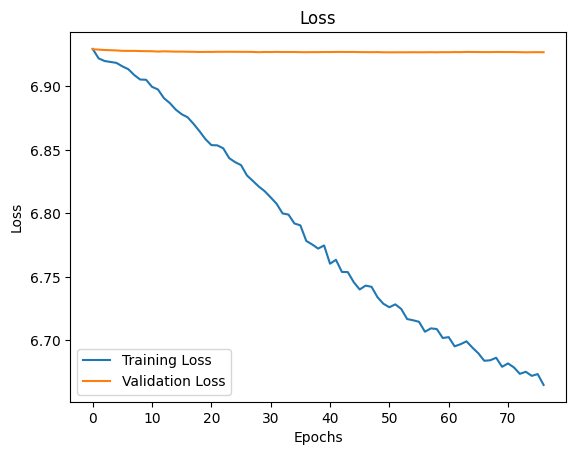

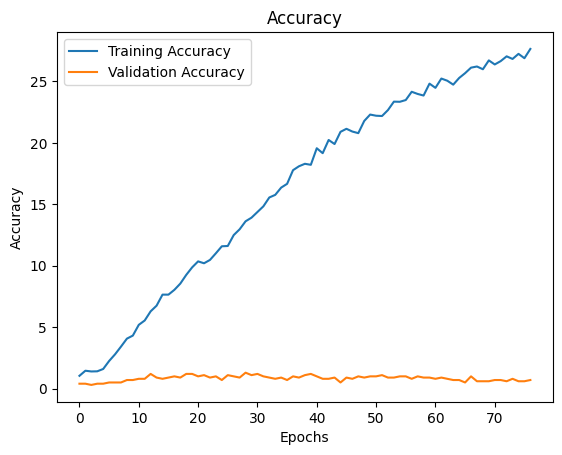

In [24]:
plot_loss(train_loss,val_loss)
plot_accuracy(train_acc,val_acc)